In [1]:
# import modules
import pandas as pd
from tensorflow.keras import metrics
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import os
from skimage import io
from tqdm import tqdm

In [2]:
# # set GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
# print(len(gpus))
# logical_gpus = tf.config.experimental.list_logical_devices('GPU')
# print(len(logical_gpus))

In [3]:
# read data
jan_train = pd.read_csv('./TrainingNew/trainingJanNum1.csv')

In [4]:
#数据归一化
jan_train_x = pd.concat([jan_train.iloc[:,1:8]/jan_train.iloc[:,1:8].max(),
                         jan_train.iloc[:,9:12]/jan_train.iloc[:,9:12].max()],axis=1,join='inner').values
jan_train_y = jan_train.landcover.values

In [5]:
#划分数据集
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(jan_train_x, jan_train_y, test_size=0.2, random_state=3)
print(len(X_train), len(X_test))

831 208


In [6]:
#设置训练模型相关内容，详情见 https://keras.io/zh/callbacks/
logdir = os.path.join("model")
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,monitor='val_accuracy',save_best_only = True,save_weights_only = False),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, min_delta=1e-7),
]

In [7]:
#定义dnn网络结构
model = Sequential()
model.add(Dense(32, input_shape=(10,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(6))
model.add(Activation('softmax'))
#设置loss函数、优化器等
model.compile(loss="sparse_categorical_crossentropy",optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])
#训练模型
model.fit(X_train, Y_train, epochs=100, batch_size=64,shuffle=True,
          validation_data=(X_test,Y_test),callbacks=callbacks,verbose=1)

Train on 831 samples, validate on 208 samples
Epoch 1/100
831/831 [==============================] - 1s 909us/sample - loss: 1.7761 - accuracy: 0.2900 - val_loss: 1.7010 - val_accuracy: 0.4808
Epoch 2/100
831/831 [==============================] - 0s 61us/sample - loss: 1.6953 - accuracy: 0.4140 - val_loss: 1.6288 - val_accuracy: 0.4760
Epoch 3/100
831/831 [==============================] - 0s 80us/sample - loss: 1.6223 - accuracy: 0.4428 - val_loss: 1.5478 - val_accuracy: 0.4712
Epoch 4/100
831/831 [==============================] - 0s 83us/sample - loss: 1.5477 - accuracy: 0.4669 - val_loss: 1.4620 - val_accuracy: 0.5481
Epoch 5/100
831/831 [==============================] - 0s 85us/sample - loss: 1.4635 - accuracy: 0.5078 - val_loss: 1.3644 - val_accuracy: 0.5625
Epoch 6/100
831/831 [==============================] - 0s 96us/sample - loss: 1.3809 - accuracy: 0.5018 - val_loss: 1.2684 - val_accuracy: 0.6875
Epoch 7/100
831/831 [==============================] - 0s 73us/sample - loss:

In [8]:
#加载训练好的模型
model = keras.models.load_model(output_model_file)

In [9]:
#读取测试图片
jan_img = np.reshape(io.imread('./1January/Januarymask.tif'),(-1,13))
jan_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [10]:
h,w,c = io.imread('./1January/Januarymask.tif').shape

In [11]:
jan_img_b2_b8 = jan_img[:,1:8]


In [12]:
#测试图片数据预处理
ndd = jan_img[:,3]/jan_img[:,7]
ndsi = (jan_img[:,2]-jan_img[:,11])/(jan_img[:,2]+jan_img[:,11])
ndvi = (jan_img[:,7]-jan_img[:,3])/(jan_img[:,7]+jan_img[:,3])
jan_test_data = np.c_[jan_img_b2_b8,ndd,ndsi,ndvi]/np.concatenate((jan_train.iloc[:,1:8].max().values,jan_train.iloc[:,9:12].max().values))

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [13]:
#预测结果
pred = []
invalid_data = []
valid_data = []
for i in tqdm(range(len(jan_img))):
    if jan_test_data[i][0] == 0 or jan_test_data[i][0] == -1:
        pred.append(-1)
    else:
        pred.append(model.predict(jan_test_data[i][np.newaxis,::]).argmax())

  0%|          | 18175/9929820 [06:47<61:43:54, 44.60it/s] 


KeyboardInterrupt: 

In [43]:
#设置不同label的颜色
colour = []
for r in [0,255]:
    for g in [0,255]:
        for b in [0,255]:
            colour.append([r,g,b])

colour

[[0, 0, 0],
 [0, 0, 255],
 [0, 255, 0],
 [0, 255, 255],
 [255, 0, 0],
 [255, 0, 255],
 [255, 255, 0],
 [255, 255, 255]]

In [39]:
# 将预测的 0-5 标签，转化为相应的颜色，并reshape
pred_map = []
for j in pred:
    pred_map.append(colour[j+1])
    
pred_map = np.array(pred_map).reshape((h,w,3)).astype(np.uint8)

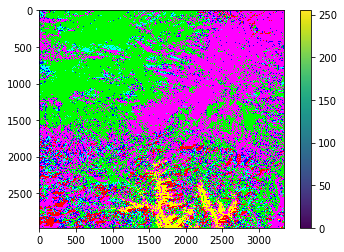

In [41]:
# 画图
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(pred_map)
plt.colorbar()
plt.show()

In [44]:
#保存图片
from PIL import Image
Image.fromarray(pred_map).save('jan_img.jpg')